# Dataset

## Parameter

In [1]:
from pathlib import Path

batch_size = 64
img_size = (244, 244)

data_path = Path('./Dataset/')
test_path = Path('./Dataset_test/')

In [2]:
image_count = len(list(data_path.glob('*/*.jpg')))
print(f'Image Found: {image_count} files')

Image Found: 11069 files


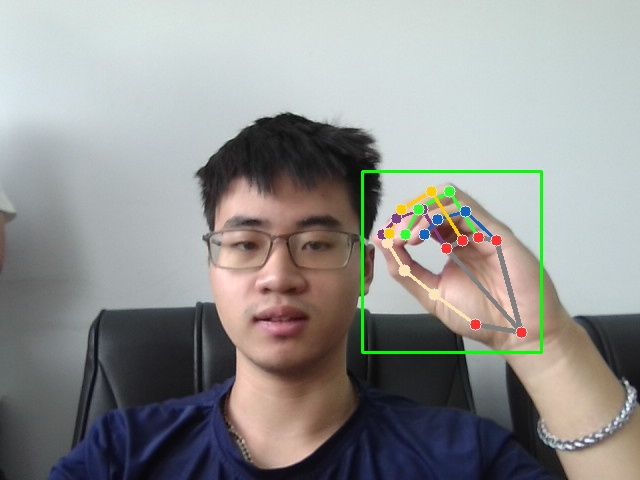

In [3]:
import PIL.Image

number_0 = list(data_path.glob('0/*'))
PIL.Image.open(number_0[0])

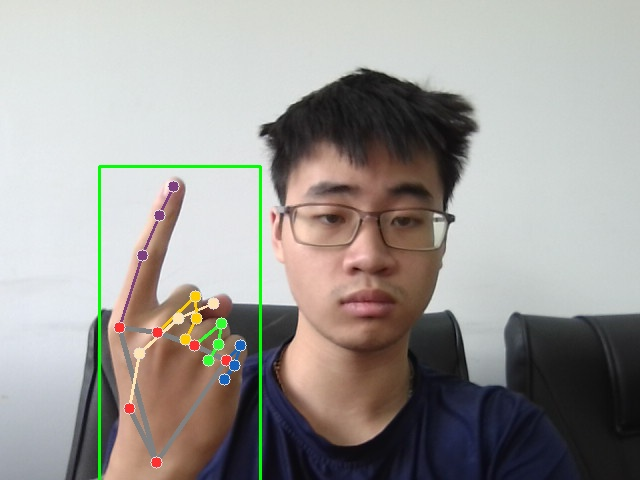

In [4]:
number_1 = list(data_path.glob('1/*'))
PIL.Image.open(number_1[0])

## Split

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train = image_dataset_from_directory(
    data_path,
    labels = "inferred",
    label_mode = "int",
    batch_size = batch_size,
    image_size = img_size,
    shuffle = True,
    seed = 123,
    validation_split = 0.2,
    subset = "training",
    verbose = True
)

train

Found 11069 files belonging to 34 classes.
Using 8856 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
val = image_dataset_from_directory(
    data_path,
    labels = "inferred",
    label_mode = "int",
    batch_size = batch_size,
    image_size = img_size,
    shuffle = True,
    seed = 123,
    validation_split = 0.2,
    subset = "validation",
    verbose = True
)

val

Found 11069 files belonging to 34 classes.
Using 2213 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
test = image_dataset_from_directory(
    test_path,
    labels = "inferred",
    label_mode = "int",
    batch_size = batch_size,
    image_size = img_size,
    shuffle = True,
    seed = 123,
    verbose = True
)

Found 120 files belonging to 4 classes.


## Visualize

In [8]:
class_names = train.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


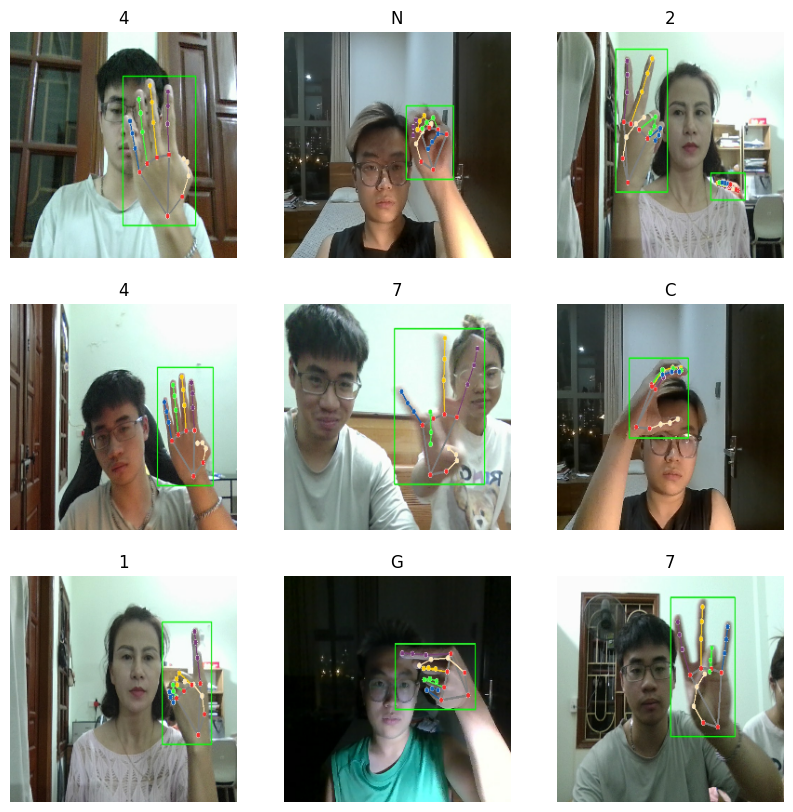

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for imgs, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

In [10]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 244, 244, 3)
(64,)


# Preprocessing

## Missing data

In [11]:
import os
from PIL import Image, UnidentifiedImageError

corrupt_images = []

for subdir, dirs, files in os.walk(data_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (UnidentifiedImageError, OSError, ValueError) as e:
            print(f"Corrupt or unreadable image: {file_path}. Error: {e}")
            corrupt_images.append(file_path)

if corrupt_images:
    print(f"\nFound {len(corrupt_images)} corrupt images:")
    for corrupt_file in corrupt_images:
        print(corrupt_file)
else:
    print("\nNo corrupt images found in the dataset.")


No corrupt images found in the dataset.


## Config data

In [12]:
from tensorflow.data import AUTOTUNE

AUTOTUNE = AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

## Normalize

In [13]:
from tensorflow.keras.layers import Rescaling

norm_layer = Rescaling(1./255, input_shape=(*img_size, 3))

train_norm = train.map(lambda x, y: (norm_layer(x), y))

d:\B3Projekt\ASL Model\b3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
import numpy as np

image_batch, labels_batch = next(iter(train_norm))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


(-0.5, 243.5, 243.5, -0.5)

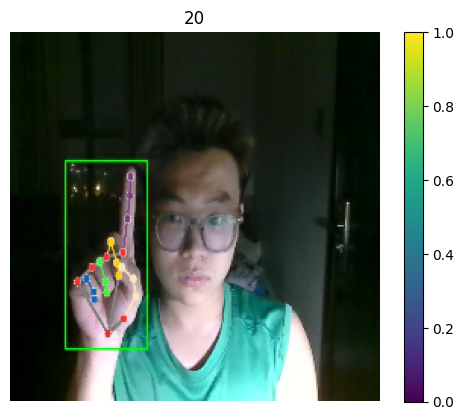

In [15]:
plt.imshow(first_image.numpy())
plt.colorbar()
plt.title(labels_batch[8].numpy())
plt.axis('off')

## Augmentation

Data augmentation is the process of artificially generating new data from existing data, primarily to train new machine learning (ML) models. ML models require large and varied datasets for initial training, but sourcing sufficiently diverse real-world datasets can be challenging because of data silos, regulations, and other limitations. Data augmentation artificially increases the dataset by making small changes to the original data

### Why is data augmentation important?

Deep learning models rely on large volumes of diverse data to develop accurate predictions in various contexts. Data augmentation supplements the creation of data variations that can help a model improve the accuracy of its predictions. Augmented data is vital in training.

Here are some of the benefits of data augmentation:

* Enhanced model performance
    - Data augmentation techniques help enrich datasets by creating many variations of existing data. This provides a larger dataset for training and enables a model to encounter more diverse features. The augmented data helps the model better generalize to unseen data and improve its overall performance in real-world environments. 

* Reduced data dependency
    - The collection and preparation of large data volumes for training can be costly and time-consuming. Data augmentation techniques increase the effectiveness of smaller datasets, vastly reducing the dependency on large datasets in training environments. You can use smaller datasets to supplement the set with synthetic data points.

* Mitigate overfitting in training data
    - Data augmentation helps prevent overfitting when you’re training ML models. Overfitting is the undesirable ML behavior where a model can accurately provide predictions for training data but it struggles with new data. If a model trains only with a narrow dataset, it can become overfit and can give predictions related to only that specific data type. In contrast, data augmentation provides a much larger and more comprehensive dataset for model training. It makes training sets appear unique to deep neural networks, preventing them from learning to work with only specific characteristics. 

* Improved data privacy
    - If you need to train a deep learning model on sensitive data, you can use augmentation techniques on the existing data to create synthetic data. This augmented data retains the input data's statistical properties and weights while protecting and limiting access to the original.

### How does data augmentation work?

Data augmentation transforms, edits, or modifies existing data to create variations. The following is a brief overview of the process.

* Dataset exploration
    - The first stage of data augmentation is to analyze an existing dataset and understand its characteristics. Features like the size of input images, the distribution of the data, or the text structure all give further context for augmentation. 

    - You can select different data augmentation techniques based on the underlying data type and the desired results. For example, augmenting a dataset with many images includes adding noise to them, scaling, or cropping them. Alternatively, augmenting a text dataset for natural language processing (NLP replaces synonyms or paraphrases excerpts. 

* Augmentation of existing data
    - After you’ve selected the data augmentation technique that work best for your desired goal, you begin applying different transformations. Data points or image samples in the dataset transform by using your selected augmentation method, providing a range of new augmented samples. 

    - During the augmentation process, you maintain the same labeling rules for data consistency, ensuring that the synthetic data includes the same labels corresponding to the source data.

    - Typically, you look through the synthetic images to determine whether the transformation succeeded. This additional human-led step helps maintain higher data quality. 

* Integrate data forms
    - Next, you combine the new, augmented data with the original data to produce a larger training dataset for the ML model. When you’re training the model, you use this composite dataset of both kinds of data.

    - It’s important to note that new data points that are created by synthetic data augmentation carry the same bias as the original input data. To prevent biases from transferring into your new data, address any bias in the source data before starting the data augmentation process.

### What are some data augmentation techniques in Computer vision?

* Data augmentation is a central technique in computer vision tasks. It helps create diverse data representations and tackle class imbalances in a training dataset. 

* The first usage of augmentation in computer vision is through position augmentation. This strategy crops, flips, or rotates an input image to create augmented images. Cropping either resizes the image or crops a small part of the original image to create a new one. Rotation, flip, and resizing transformation all alter the original randomly with a given probability of providing new images.

* Another usage of augmentation in computer vision is in color augmentation. This strategy adjusts the elementary factors of a training image, such as its brightness, contrast degree, or saturation. These common image transformations change the hue, dark and light balance, and separation between an image's darkest and lightest areas to create augmented images.

### Define

In [16]:
from tensorflow.keras.layers import RandomRotation, RandomFlip, GaussianNoise, RandomZoom, RandomTranslation
from tensorflow import image
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.image import sobel_edges, rgb_to_grayscale

def de_texturize(image):
    return sobel_edges(image)

def de_colorize(image):
    return rgb_to_grayscale(image)

def edge_enhance(image):
    edges = sobel_edges(image)
    return image + edges

def salient_edge_map(image):
    grayscale = rgb_to_grayscale(image)
    return sobel_edges(grayscale)  

In [17]:
data_augmentation = Sequential()

#data_augmentation.add(RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)))  # Zoom adjustment
#data_augmentation.add(RandomTranslation(height_factor=0.2, width_factor=0.2))           # Translation adjustment
#data_augmentation.add(GaussianNoise(0.1))
#data_augmentation.add(Lambda(lambda x: image.adjust_contrast(x, 1.2)))                  # Contrast adjustment
#data_augmentation.add(Lambda(lambda x: image.adjust_brightness(x, 0.1)))                # Brightness adjustment
#data_augmentation.add(Lambda(lambda x: de_texturize(x)))
#data_augmentation.add(Lambda(lambda x: edge_enhance(x)))
#data_augmentation.add(Lambda(lambda x: salient_edge_map(x)))
#data_augmentation.add(Lambda(lambda x: de_colorize(x)))

# Model

## ResNet

## Mediapipe